In [22]:
from Core_Game_Parts import *
import os
import pygame
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import time
import random
from collections import deque
import matplotlib.pyplot as plt

os.environ["SDL_VIDEODRIVER"] = "dummy"

In [23]:
def model_rl():
    """Builds the model with a linear output layer suitable for Q-learning."""
    net = Sequential([
        Dense(64, activation='relu', input_shape=(4,)),
        Dense(64, activation='relu'),
        Dense(3, activation='linear') # Linear output for Q-values
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    net.compile(optimizer=optimizer, loss='mse')
    return net


In [24]:
class DQNAgent:
    """
    A Deep Q-Network (DQN) agent for reinforcement learning.
    Attributes:
        model: The neural network model used for approximating Q-values.
        memory: A deque to store past experiences for experience replay.
        gamma: Discount factor for future rewards.
        epsilon: Exploration rate for the epsilon-greedy policy.
        epsilon_min: Minimum exploration rate.
        epsilon_decay: Decay rate for exploration after each training episode.
        batch_size: Size of the minibatch for training.
    Methods:
        remember: Store an experience in memory.
        choose_action: Select an action based on the current state using an epsilon-greedy policy.
        train_from_memory: Train the model using a minibatch of experiences from memory.
    """
    def __init__(self, model_fn):
        self.model = model_fn()
        self.target_model = model_fn()
        self.update_target_model()
        self.memory = deque(maxlen=20000)
        self.gamma = 0.99
        self.epsilon = 1.0 # Will be reset after loading weights
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.batch_size = 128

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(3)
        q_values = self.model.predict(np.reshape(state, [1, 4]), verbose=0)
        return np.argmax(q_values[0])

    def train_from_memory(self):
        if len(self.memory) < self.batch_size: return None
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([exp[0] for exp in minibatch])
        actions = np.array([exp[1] for exp in minibatch])
        rewards = np.array([exp[2] for exp in minibatch])
        next_states = np.array([exp[3] for exp in minibatch])
        dones = np.array([exp[4] for exp in minibatch])
        
        current_q_values = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)
        
        targets = rewards + self.gamma * np.amax(next_q_values, axis=1) * (1 - dones)
        
        for i, action in enumerate(actions):
            current_q_values[i][action] = targets[i]
            
        history = self.model.fit(states, current_q_values, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return history.history['loss'][0]


In [ ]:
def model_game_step(action, car, track_image, current_checkpoint):
    done = False
    reward = -0.05
    if car.speed < 0.2: reward -= 0.5
    reward += car.speed * 0.5
    current_state, _ = ray_casting(car, track_image)
    reward += current_state[1] * 0.005
    track_surface = pygame.image.load(TRACK_IMAGE_PATH).convert()

    car.speed += ACCELERATION
    if car.speed > 0:
        speed_factor = car.speed / MAX_SPEED
        turn_angle = MAX_TURN_ANGLE - (speed_factor) * (MAX_TURN_ANGLE - MIN_TURN_ANGLE)
        if action == 0: car.angle += turn_angle
        elif action == 1: car.angle -= turn_angle
    if action == 2: car.speed -= BRAKE_FORCE
    car.speed -= FRICTION
    car.speed = max(0, min(car.speed, MAX_SPEED))
    car.move()
    
    checkpoint_rects = [pygame.Rect(x,y,w,h) for x,y,w,h,a in checkpoint_data]
    if current_checkpoint < len(checkpoint_rects):
        if car.rect.colliderect(checkpoint_rects[current_checkpoint]):
            current_checkpoint += 1
            reward += 1000
            print(f"Checkpoint {current_checkpoint} reached!")
    
    if current_checkpoint == len(checkpoint_rects) and car.rect.colliderect(finish_line_rect):
        reward += 10000
        current_checkpoint = 0
        print("Lap finished!")
    try:
        if track_surface.get_at((int(car.x), int(car.y)))[:3] == DRAW_COLOR: done = True  #chanhe to track_surface if not working 
    except IndexError: done = True
    if done: reward = -100
    new_state, _ = ray_casting(car, track_image)
    return new_state, done, reward, current_checkpoint


In [ ]:
def train_dqn_finetune(episodes=500, pretrained_weights_path="pretrained_weights.h5"):
    pygame.init()
    screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
    track_surface = pygame.image.load(TRACK_IMAGE_PATH).convert()
    agent = DQNAgent(model_rl)

    try:
        agent.model.load_weights(pretrained_weights_path)
        agent.update_target_model()
        print(f"Successfully loaded pre-trained weights from {pretrained_weights_path}")
    except Exception as e:
        print(f"Could not load pre-trained weights: {e}. Starting from scratch.")

    agent.epsilon = 0.1 # Start with low epsilon for fine-tuning
    print(f"Starting fine-tuning with epsilon = {agent.epsilon}")
    
    history_data = {'scores': [], 'loss': [], 'checkpoints': [], 'max_speed': []}
    
    for e in range(episodes):
        car = Car(CAR_IMAGE_PATH, DEFAULT_START_X, DEFAULT_START_Y, DEFAULT_START_ANGLE)
        current_checkpoint, total_reward, max_speed_episode, min_speed_episode = 0, 0, 0, 5
        distances, _ = ray_casting(car, track_surface)
        state = np.array(distances + [car.speed / MAX_SPEED])
        
        for step in range(30000): # Max steps per episode
            action = agent.choose_action(state)
            distances_next, done, reward, new_checkpoint = model_game_step(action, car, track_surface, current_checkpoint)
            
            max_speed_episode = max(max_speed_episode, car.speed)
            min_speed_episode = min(min_speed_episode, car.speed)
            total_reward += reward
            next_state = np.array(distances_next + [car.speed / MAX_SPEED])
            current_checkpoint = new_checkpoint
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            
            if step % 8 == 0:
                loss = agent.train_from_memory()
                if loss is not None: history_data['loss'].append(loss)
            
            if done:
                break
        
        if (e + 1) % 5 == 0:
            agent.update_target_model()
            print(f"--- Target Network Updated at Episode {e+1} ---")
            
        history_data['scores'].append(total_reward)
        history_data['checkpoints'].append(current_checkpoint)
        history_data['max_speed'].append(max_speed_episode)
        
        print(f"E{e+1}/{episodes}, Score:{total_reward:.2f}, Max speed:{max_speed_episode:.2f}, Min speed:{min_speed_episode:.2f}, Ckpt:{current_checkpoint}")
        
        if (e + 1) % 50 == 0:
            # Save with a new name to distinguish from pre-trained weights
            agent.model.save_weights(f"finetuned_weights_episode_{e+1}.weights.h5")
            print(f"Saved fine-tuned weights at episode {e+1}")

    pygame.quit()

    # --- Plotting the results ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(4, 1, figsize=(12, 22))
    (ax1, ax2, ax3, ax4) = axes
    
    ax1.plot(history_data['scores'], label='Score per Episode', color='royalblue')
    ax1.set(title='Agent Score Over Time', xlabel='Episode', ylabel='Total Reward')
    ax1.legend()

    ax2.plot(history_data['max_speed'], label='Max Speed', color='purple')
    ax2.set(title='Max Speed Achieved per Episode', xlabel='Episode', ylabel='Max Speed')
    ax2.legend()
    
    ax3.plot(history_data['loss'], label='Training Loss', color='orangered', alpha=0.7)
    ax3.set(title='Model Loss Over Time', xlabel='Training Step', ylabel='MSE Loss')
    ax3.legend()

    episodes_range = range(len(history_data['checkpoints']))
    ax4.bar(episodes_range, history_data['checkpoints'], color='forestgreen', label='Checkpoints')
    ax4.set(title='Checkpoints Cleared per Episode', xlabel='Episode', ylabel='Checkpoints Cleared')
    ax4.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax4.legend()

    plt.tight_layout()
    plt.show()

✅ Successfully loaded pre-trained weights from pretrained.weights.h5
Starting fine-tuning with epsilon = 0.1
E1/1000, Score:64.47, Speed:2.90, Ckpt:0, Eps:0.10
E2/1000, Score:51.09, Speed:2.95, Ckpt:0, Eps:0.10
E3/1000, Score:30.01, Speed:2.85, Ckpt:0, Eps:0.10
E4/1000, Score:-48.07, Speed:0.85, Ckpt:0, Eps:0.10
--- Target Network Updated at Episode 5 ---
E5/1000, Score:-86.83, Speed:1.03, Ckpt:0, Eps:0.10
E6/1000, Score:-87.69, Speed:0.98, Ckpt:0, Eps:0.10
E7/1000, Score:-87.93, Speed:0.95, Ckpt:0, Eps:0.10
E8/1000, Score:-89.05, Speed:1.00, Ckpt:0, Eps:0.09
E9/1000, Score:-87.57, Speed:0.93, Ckpt:0, Eps:0.09
--- Target Network Updated at Episode 10 ---
E10/1000, Score:-78.70, Speed:0.97, Ckpt:0, Eps:0.09
E11/1000, Score:-79.76, Speed:0.95, Ckpt:0, Eps:0.09
E12/1000, Score:-91.61, Speed:0.93, Ckpt:0, Eps:0.09
E13/1000, Score:-12.13, Speed:1.90, Ckpt:0, Eps:0.09
E14/1000, Score:-8.73, Speed:2.10, Ckpt:0, Eps:0.09
--- Target Network Updated at Episode 15 ---
E15/1000, Score:-0.39, Speed

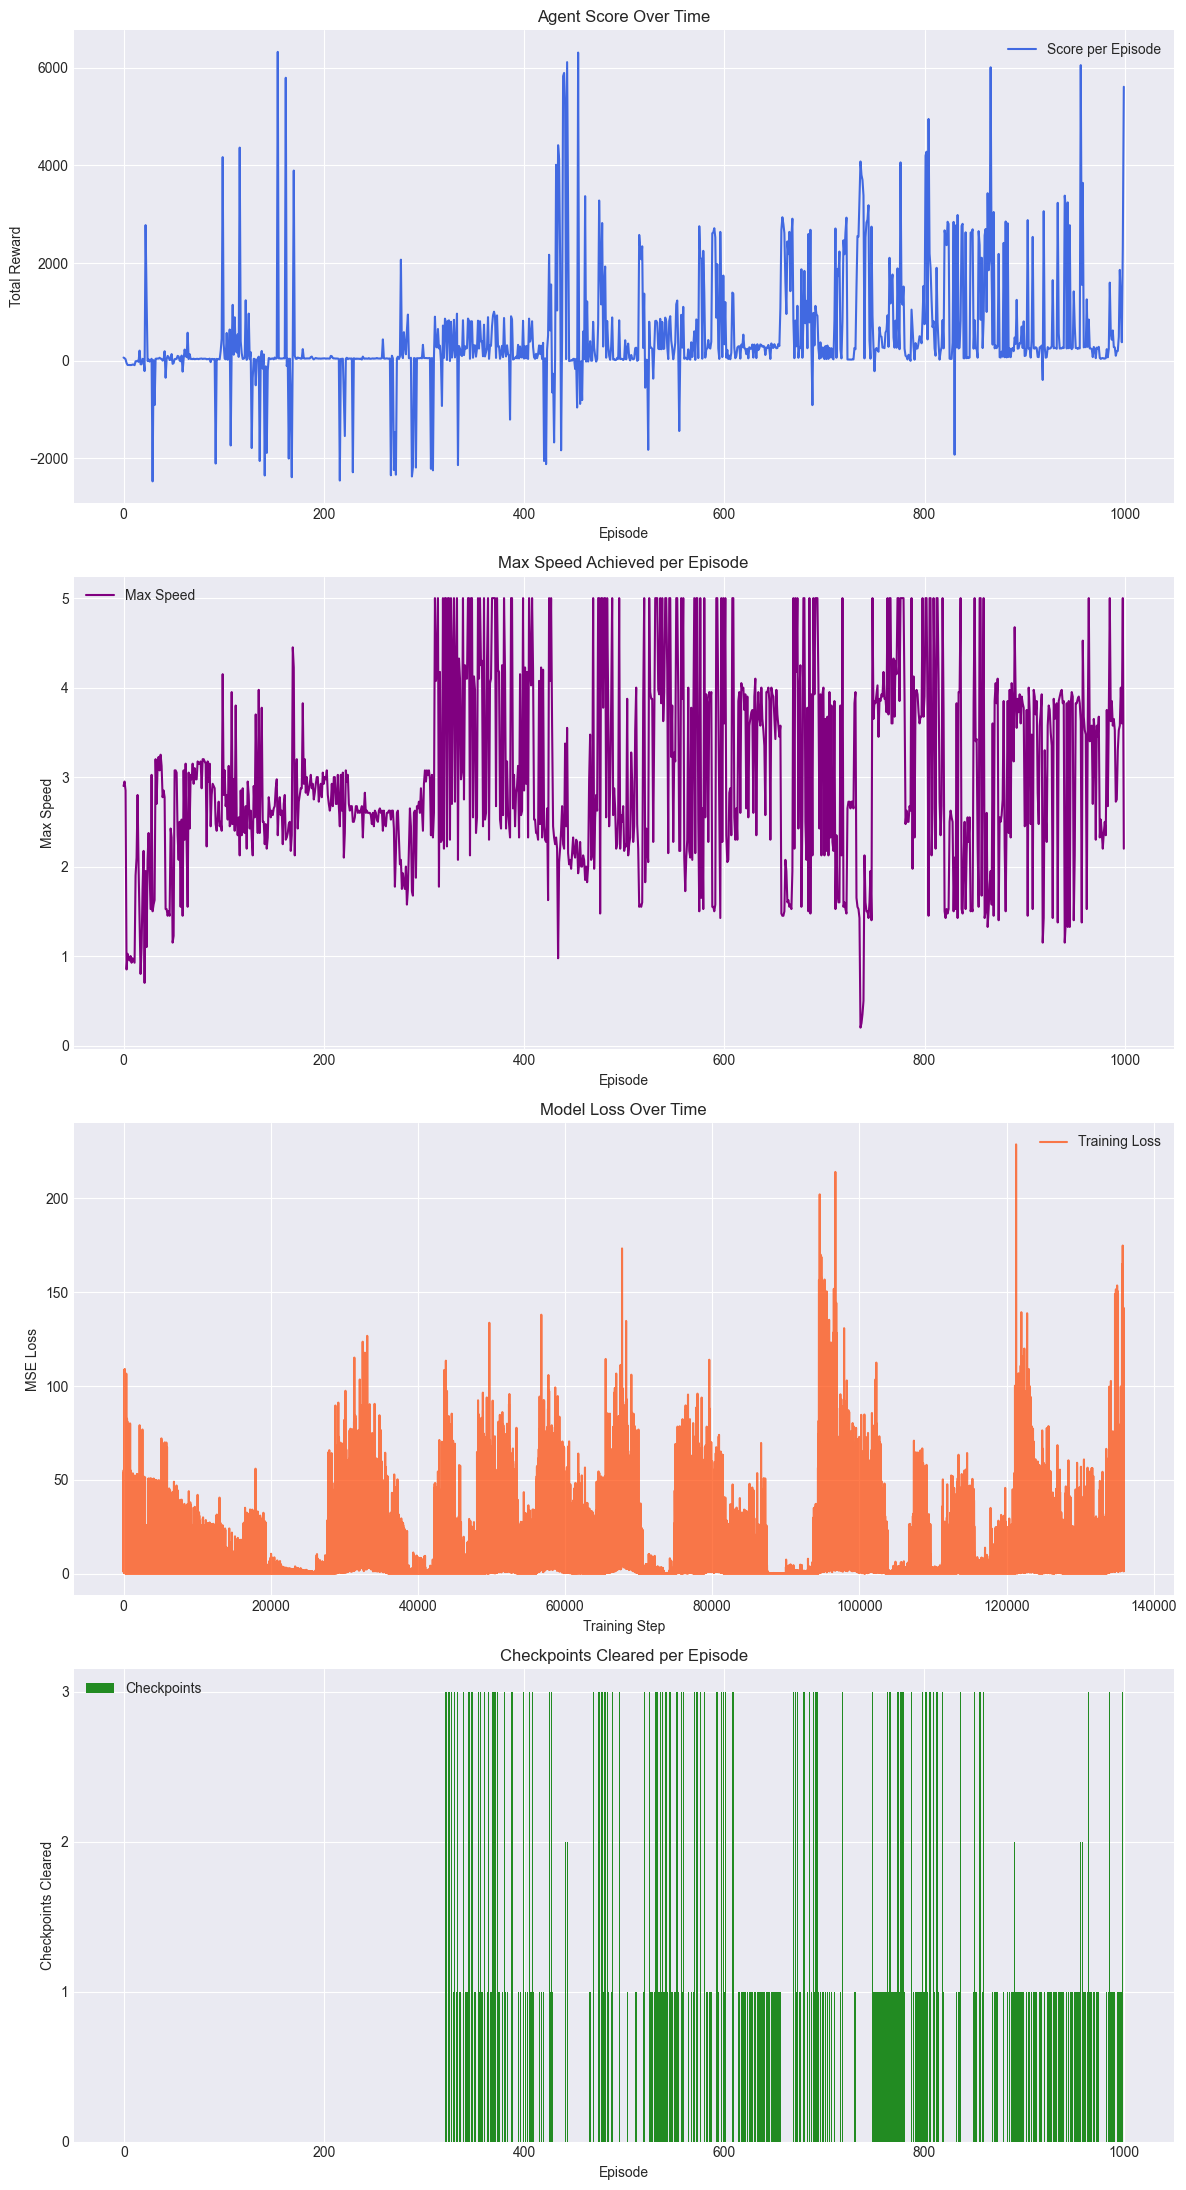

In [28]:
if __name__=="__main__":
    train_dqn_finetune(episodes=1000, pretrained_weights_path="pretrained.weights.h5")